## Note: the cells below until Feature Selection is same as Multi_Ce_RandomForest.ipynb

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV, train_test_split, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
import lightgbm as lgb
from bayes_opt import BayesianOptimization
import warnings
import xgboost as xgb

# Import Data

In [198]:
df = pd.read_csv("combined_df.csv")
df = df[
    (df['Year'] >= 2020) &
    ((df['Headliner'].str.contains('"', na=False))) & 
    (df['Genre'] != 'Family Entertainment') &
    (df['Ticket Price Min USD'] > 0) &
    (df['Ticket Price Min USD'] < df['Ticket Price Max USD'])
]
# df = df.dropna()
# # Reset index after dropping rows
# df = df.reset_index(drop=True)
df

,Event Date,Headliner,sp artist_name,sp artist_genre,sp followers,sp popularity,yt name,yt Channel ID,yt Title,yt Description,...,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,Ticket Price Avg. USD,Month,day_of_week
7,2024-09-11,"Greg ""G"" Williams",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Comedy,40.0,1240.00,220.0,18%,25.0,35.0,31.00,9,2
56,2024-09-05,"""K-Pop Club Night""","""K-Pop Club Night""","['k-pop', 'k-pop girl group']",9156939.0,82.0,"""K-Pop Club Night""",UCSSEYmHc2HGnFWwHhRXY5kA,P Su,NaN,...,Pop / Rock,361.0,9113.00,1600.0,22%,22.0,35.0,25.24,9,3
60,2024-09-05,"""RuPaul's Drag Race""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Theatrical,1524.0,108716.75,3048.0,50%,25.0,99.5,71.34,9,3
80,2024-09-03,"""Avatar: The Last Airbender In Concert""","""Avatar: The Last Airbender In Concert""","['pixel', 'video game music']",1025270.0,73.0,"""Avatar: The Last Airbender In Concert""",UCugEMaKUpe62yldZ2DECTEQ,Robert Van Der Vliet,NaN,...,Pop / Rock,689.0,36846.00,1881.0,36%,20.0,125.0,53.48,9,1
93,2024-09-01,"""RuPaul's Drag Race""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Theatrical,2108.0,162809.00,2704.0,77%,49.5,99.5,77.23,9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109659,2020-01-02,"Cirque du Soleil - ""Axel""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Theatrical,3280.0,200146.17,20000.0,16%,25.0,110.0,61.01,1,3
109663,2020-01-02,"Cirque du Soleil - ""Ovo""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Theatrical,1142.0,63001.50,3908.0,29%,39.0,125.0,55.16,1,3
109672,2020-01-01,"""Voices On The Hudson"", Joseph Arthur",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Americana, Multi-Genre",89.0,2810.00,100.0,89%,30.0,35.0,31.40,1,2
109682,2020-01-01,"""Hangover Ball""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Pop / Rock,1119.0,26255.00,1700.0,65%,22.0,42.0,23.46,1,2


In [199]:
# Calculate # and % of missing values in each column
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})

# sort missing values
missing_df = missing_df.sort_values(by='Missing Values', ascending=False)
missing_df

,Missing Values,Percentage
yt Description,8938,99.068943
yt View Count,8870,98.315229
yt Video Count,8870,98.315229
yt name,8870,98.315229
yt Channel ID,8870,98.315229
yt Title,8870,98.315229
yt Subscriber Count,8870,98.315229
yt Published At,8870,98.315229
35 to 44 years population,8866,98.270893
45 to 54 years population,8866,98.270893


In [200]:
# just keep columns with < 80% missing values
columns_to_keep = []
for col in df.columns:
    if missing_percent[col] < 80:
        columns_to_keep.append(col)

df_filtered = df[columns_to_keep]
df_filtered.head()

,Event Date,Headliner,Year,headliner_monthly_listeners,Support_Total_Monthly_Listeners,monthly_listeners,Number of Shows,Support,Venue,City,...,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,Ticket Price Avg. USD,Month,day_of_week
7,2024-09-11,"Greg ""G"" Williams",2024.0,0.0,0.0,NaN,1,NaN,City Winery Pittsburgh,Pittsburgh,...,Comedy,40.0,1240.00,220.0,18%,25.0,35.0,31.00,9,2
56,2024-09-05,"""K-Pop Club Night""",2024.0,0.0,0.0,NaN,1,NaN,Big Night Live,Boston,...,Pop / Rock,361.0,9113.00,1600.0,22%,22.0,35.0,25.24,9,3
60,2024-09-05,"""RuPaul's Drag Race""",2024.0,0.0,0.0,NaN,1,NaN,Altria Theater,Richmond,...,Theatrical,1524.0,108716.75,3048.0,50%,25.0,99.5,71.34,9,3
80,2024-09-03,"""Avatar: The Last Airbender In Concert""",2024.0,0.0,0.0,NaN,1,NaN,Washington Pavilion of Arts and Science - Mary...,Sioux Falls,...,Pop / Rock,689.0,36846.00,1881.0,36%,20.0,125.0,53.48,9,1
93,2024-09-01,"""RuPaul's Drag Race""",2024.0,0.0,0.0,NaN,1,NaN,DPAC,Durham,...,Theatrical,2108.0,162809.00,2704.0,77%,49.5,99.5,77.23,9,6


In [201]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9022 entries, 7 to 109685
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Event Date                       9022 non-null   object 
 1   Headliner                        9022 non-null   object 
 2   Year                             9022 non-null   float64
 3   headliner_monthly_listeners      9022 non-null   float64
 4   Support_Total_Monthly_Listeners  9022 non-null   float64
 5   monthly_listeners                1888 non-null   float64
 6   Number of Shows                  9022 non-null   int64  
 7   Support                          2029 non-null   object 
 8   Venue                            9022 non-null   object 
 9   City                             9022 non-null   object 
 10  State                            9022 non-null   object 
 11  Country                          9022 non-null   object 
 12  Market                 

In [202]:
# let consider monthly_listeners's effect, which has 79% missing value
print(df_filtered.groupby(df['monthly_listeners'].isnull())['Avg. Gross USD'].mean())

monthly_listeners
False    419099.173554
True      84256.754404
Name: Avg. Gross USD, dtype: float64


In [203]:
# corr for numerical feature
correlation_matrix = df_filtered.select_dtypes(include=['number']).corr()
print(correlation_matrix['Avg. Gross USD'].sort_values(ascending=False))

Avg. Gross USD                     1.000000
Avg. Tickets Sold                  0.872640
Avg. Event Capacity                0.786855
Ticket Price Max USD               0.568861
Support_Total_Monthly_Listeners    0.488328
monthly_listeners                  0.475429
Ticket Price Avg. USD              0.447727
Ticket Price Min USD               0.404142
Month                              0.041584
day_of_week                        0.025197
Number of Shows                    0.007792
headliner_monthly_listeners       -0.000263
Year                              -0.034602
Name: Avg. Gross USD, dtype: float64


In [204]:
# monthly_listeners takes a quite big role, 
# so we can fill na with median (with same artist) first
df_filtered = df_filtered.copy()
df_filtered.loc[:, 'monthly_listeners'] = df_filtered.groupby('Headliner')['monthly_listeners'].transform(lambda x: x.fillna(x.median()))

# then fill the remaining NaNs with the global median
df_filtered.loc[:, 'monthly_listeners'] = df_filtered['monthly_listeners'].fillna(df_filtered['monthly_listeners'].median())

# check monthly_listener missing value again
print("Missing values in monthly_listeners after final fill:", df_filtered['monthly_listeners'].isnull().sum())

Missing values in monthly_listeners after final fill: 0


In [205]:
# fill other features missing value
df_filtered = df_filtered.copy()

df_filtered.loc[:, 'Support'] = df_filtered['Support'].fillna(df_filtered['Support'].mode()[0])
df_filtered.loc[:, 'Market'] = df_filtered['Market'].fillna(df_filtered['Market'].mode()[0])
df_filtered.loc[:, 'Promoter'] = df_filtered['Promoter'].fillna(df_filtered['Promoter'].mode()[0])
df_filtered.loc[:, 'Genre'] = df_filtered['Genre'].fillna(df_filtered['Genre'].mode()[0])

In [206]:
print(df_filtered.dtypes)

Event Date                          object
Headliner                           object
Year                               float64
headliner_monthly_listeners        float64
Support_Total_Monthly_Listeners    float64
monthly_listeners                  float64
Number of Shows                      int64
Support                             object
Venue                               object
City                                object
State                               object
Country                             object
Market                              object
Company Type                        object
Currency                            object
Promoter                            object
Genre                               object
Avg. Tickets Sold                  float64
Avg. Gross USD                     float64
Avg. Event Capacity                float64
Avg. Capacity Sold                  object
Ticket Price Min USD               float64
Ticket Price Max USD               float64
Ticket Pric

In [207]:
# Ensure the Event Date is datetime type
df_filtered['Event Date'] = pd.to_datetime(df_filtered['Event Date'], errors='coerce')

df_filtered['Event Year'] = df_filtered['Event Date'].dt.year
df_filtered['Event Month'] = df_filtered['Event Date'].dt.month
df_filtered['Event Day'] = df_filtered['Event Date'].dt.day
df_filtered['Day of Week'] = df_filtered['Event Date'].dt.dayofweek  # 0=Monday, 6=Sunday

df_filtered.drop(columns=['Event Date'], inplace=True)

In [208]:
# check other feature's missing value
print(df_filtered.isnull().sum())

Headliner                          0
Year                               0
headliner_monthly_listeners        0
Support_Total_Monthly_Listeners    0
monthly_listeners                  0
Number of Shows                    0
Support                            0
Venue                              0
City                               0
State                              0
Country                            0
Market                             0
Company Type                       0
Currency                           0
Promoter                           0
Genre                              0
Avg. Tickets Sold                  0
Avg. Gross USD                     0
Avg. Event Capacity                0
Avg. Capacity Sold                 0
Ticket Price Min USD               0
Ticket Price Max USD               0
Ticket Price Avg. USD              0
Month                              0
day_of_week                        0
Event Year                         0
Event Month                        0
E

In [209]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9022 entries, 7 to 109685
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Headliner                        9022 non-null   object 
 1   Year                             9022 non-null   float64
 2   headliner_monthly_listeners      9022 non-null   float64
 3   Support_Total_Monthly_Listeners  9022 non-null   float64
 4   monthly_listeners                9022 non-null   float64
 5   Number of Shows                  9022 non-null   int64  
 6   Support                          9022 non-null   object 
 7   Venue                            9022 non-null   object 
 8   City                             9022 non-null   object 
 9   State                            9022 non-null   object 
 10  Country                          9022 non-null   object 
 11  Market                           9022 non-null   object 
 12  Company Type           

# Feature Selection

In [211]:
# Goal: encoding all categroical features and rank all features' score by using feature importance
# use different ways to encode different categorical features.

In [212]:
df_filtered = df_filtered.copy()
# Frequency Encoding
high_cardinality_cols = ['Headliner', 'Support', 'Venue', 'City', 'State', 'Country', 'Market', 'Promoter']

for col in high_cardinality_cols:
    freq_encoding = df_filtered[col].value_counts().to_dict()
    df_filtered.loc[:, col] = df_filtered[col].map(freq_encoding)


# Ordinal Encoder
ordinal_cols = ['Company Type', 'Currency', 'Genre']

ordinal_encoder = OrdinalEncoder()
df_filtered.loc[:, ordinal_cols] = ordinal_encoder.fit_transform(df_filtered[ordinal_cols])

# One-Hot Encoding
df_filtered = pd.get_dummies(df_filtered, columns=['Avg. Capacity Sold'], drop_first=True)

# check type
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9022 entries, 7 to 109685
Columns: 134 entries, Headliner to Avg. Capacity Sold_99%
dtypes: bool(106), float64(10), int32(4), int64(3), object(11)
memory usage: 2.8+ MB


In [213]:
# check all object type feature in dataframe
categorical_columns = df_filtered.select_dtypes(include=['object']).columns
print("those columns are still categorical feature, need tansform", categorical_columns)

# use category convert
for col in categorical_columns:
    df_filtered[col] = df_filtered[col].astype('category').cat.codes

print(df_filtered.dtypes)

those columns are still categorical feature, need tansform Index(['Headliner', 'Support', 'Venue', 'City', 'State', 'Country', 'Market',
       'Company Type', 'Currency', 'Promoter', 'Genre'],
      dtype='object')
Headliner                             int8
Year                               float64
headliner_monthly_listeners        float64
Support_Total_Monthly_Listeners    float64
monthly_listeners                  float64
                                    ...   
Avg. Capacity Sold_95%                bool
Avg. Capacity Sold_96%                bool
Avg. Capacity Sold_97%                bool
Avg. Capacity Sold_98%                bool
Avg. Capacity Sold_99%                bool
Length: 134, dtype: object


In [214]:
df_filtered

,Headliner,Year,headliner_monthly_listeners,Support_Total_Monthly_Listeners,monthly_listeners,Number of Shows,Support,Venue,City,State,...,Avg. Capacity Sold_90%,Avg. Capacity Sold_91%,Avg. Capacity Sold_92%,Avg. Capacity Sold_93%,Avg. Capacity Sold_94%,Avg. Capacity Sold_95%,Avg. Capacity Sold_96%,Avg. Capacity Sold_97%,Avg. Capacity Sold_98%,Avg. Capacity Sold_99%
7,0,2024.0,0.0,0.0,1657487.0,1,21,26,46,37,...,False,False,False,False,False,False,False,False,False,False
56,9,2024.0,0.0,0.0,1657487.0,1,21,65,85,41,...,False,False,False,False,False,False,False,False,False,False
60,39,2024.0,0.0,0.0,1657487.0,1,21,50,70,33,...,False,False,False,False,False,False,False,False,False,False
80,14,2024.0,0.0,0.0,1657487.0,1,21,43,48,17,...,False,False,False,False,False,False,False,False,False,False
93,39,2024.0,0.0,0.0,1657487.0,1,21,62,71,43,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109659,2,2020.0,0.0,0.0,1657487.0,6,21,10,77,35,...,False,False,False,False,False,False,False,False,False,False
109663,8,2020.0,0.0,0.0,1657487.0,6,21,3,7,42,...,False,False,False,False,False,False,False,False,False,False
109672,0,2020.0,0.0,0.0,1657487.0,2,21,27,86,46,...,False,False,False,False,False,False,False,False,False,False
109682,0,2020.0,0.0,1120797.0,1120797.0,1,0,0,30,15,...,False,False,False,False,False,False,False,False,False,False


# Train the Model

## Default LightGBM


=== Top 10 Features ===
['Avg. Tickets Sold', 'Ticket Price Avg. USD', 'Ticket Price Min USD', 'Avg. Event Capacity', 'Ticket Price Max USD', 'Support_Total_Monthly_Listeners', 'monthly_listeners', 'Event Day', 'Market', 'Genre']


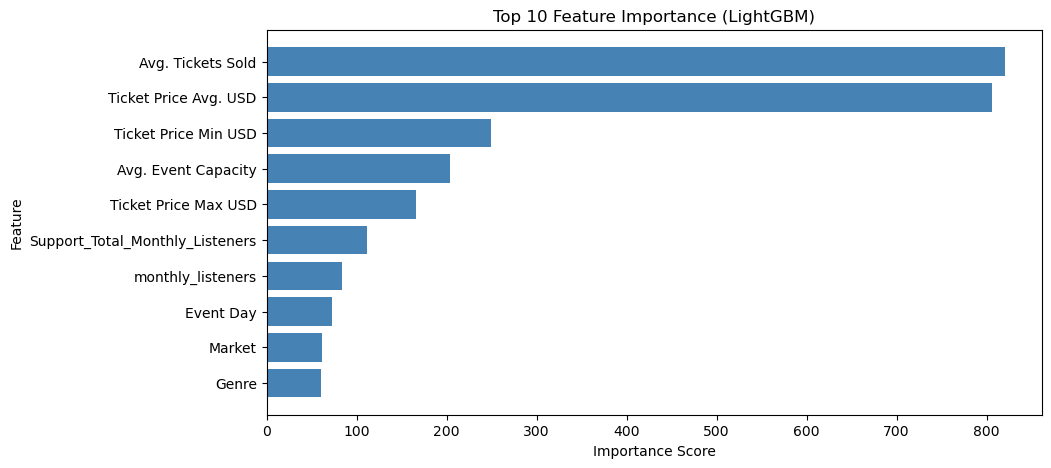

In [217]:
target = 'Avg. Gross USD'
features = [col for col in df_filtered.columns if col != target]

X = df_filtered[features]
y = df_filtered[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train LightGBM and get feature importance
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# choose top 10
top_10_features = feature_importance['Feature'].head(10).tolist()
print("\n=== Top 10 Features ===")
print(top_10_features)

plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10), color='steelblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance (LightGBM)')
plt.show()

In [218]:
# reset train & test set (only use top 10)
X_train_top = X_train[top_10_features]
X_test_top = X_test[top_10_features]
X_train_top.columns = X_train_top.columns.str.replace(" ", "_")
X_test_top.columns = X_test_top.columns.str.replace(" ", "_")

# train default LightGBM
default_lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)

# cv
cv_mae = cross_val_score(default_lgb_model, X_train_top, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(default_lgb_model, X_train_top, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_r2 = cross_val_score(default_lgb_model, X_train_top, y_train, cv=5, scoring='r2')

print("\n=== Default LightGBM Cross-Validation Results (Training Set) ===")
print(f" Average MAE: {-np.mean(cv_mae):.5f}")
print(f" Average RMSE: {-np.mean(cv_rmse):.5f}")
print(f" Average R²: {np.mean(cv_r2):.5f}")

# train
default_lgb_model.fit(X_train_top, y_train)

# predict
y_test_pred = default_lgb_model.predict(X_test_top)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\n=== Default LightGBM Test Set Results ===")
print(f" MAE: {test_mae:.5f}")
print(f" RMSE: {test_rmse:.5f}")
print(f" R²: {test_r2:.5f}")


=== Default LightGBM Cross-Validation Results (Training Set) ===
 Average MAE: 16151.69223
 Average RMSE: 149178.96456
 Average R²: 0.86545

=== Default LightGBM Test Set Results ===
 MAE: 13888.88466
 RMSE: 140143.33443
 R²: 0.91915


## XGBoost

In [220]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# CV
cv_mae = cross_val_score(xgb_model, X_train_top, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(xgb_model, X_train_top, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_r2 = cross_val_score(xgb_model, X_train_top, y_train, cv=5, scoring='r2')

print("\n=== XGBoost Cross-Validation Results (Training Set) ===")
print(f" Average MAE: {-np.mean(cv_mae):.5f}")
print(f" Average RMSE: {-np.mean(cv_rmse):.5f}")
print(f" Average R²: {np.mean(cv_r2):.5f}")

xgb_model.fit(X_train_top, y_train)

y_test_pred = xgb_model.predict(X_test_top)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\n=== XGBoost Test Set Results ===")
print(f" MAE: {test_mae:.5f}")
print(f" RMSE: {test_rmse:.5f}")
print(f" R²: {test_r2:.5f}")


=== XGBoost Cross-Validation Results (Training Set) ===
 Average MAE: 11146.85495
 Average RMSE: 99581.75019
 Average R²: 0.93806

=== XGBoost Test Set Results ===
 MAE: 16488.97342
 RMSE: 193693.97396
 R²: 0.84555


## Ensemble

### Averaging

In [260]:
cv_preds_lgb = cross_val_predict(default_lgb_model, X_train_top, y_train, cv=5)
cv_preds_xgb = cross_val_predict(xgb_model, X_train_top, y_train, cv=5)

# alpha = 0.5  # 50% LightGBM + 50% XGBoost
alpha = 0.7  # 70% LightGBM + 30% XGBoost


# ensemble
cv_preds_ensemble = alpha * cv_preds_lgb + (1 - alpha) * cv_preds_xgb

cv_mae = mean_absolute_error(y_train, cv_preds_ensemble)
cv_rmse = np.sqrt(mean_squared_error(y_train, cv_preds_ensemble))
cv_r2 = r2_score(y_train, cv_preds_ensemble)

print("\n=== Averaging Ensemble Cross-Validation Results (Training Set) ===")
print(f" Average MAE: {cv_mae:.5f}")
print(f" Average RMSE: {cv_rmse:.5f}")
print(f" Average R²: {cv_r2:.5f}")

y_pred_lgb = default_lgb_model.predict(X_test_top)
y_pred_xgb = xgb_model.predict(X_test_top)

y_pred_ensemble = alpha * y_pred_lgb + (1 - alpha) * y_pred_xgb

test_mae = mean_absolute_error(y_test, y_pred_ensemble)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
test_r2 = r2_score(y_test, y_pred_ensemble)

print("\n=== Averaging Ensemble Test Set Results ===")
print(f" MAE: {test_mae:.5f}")
print(f" RMSE: {test_rmse:.5f}")
print(f" R²: {test_r2:.5f}")


=== Averaging Ensemble Cross-Validation Results (Training Set) ===
 Average MAE: 13117.98609
 Average RMSE: 132773.05203
 Average R²: 0.89657

=== Averaging Ensemble Test Set Results ===
 MAE: 13394.23073
 RMSE: 150135.67388
 R²: 0.90720


### Stacking (2nd layer: linear regression)

In [269]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np

# set k fold to 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_meta = np.zeros((X_train_top.shape[0], 2))
test_meta = np.zeros((X_test_top.shape[0], 2))
test_meta_kfold = np.zeros((5, X_test_top.shape[0], 2))

# First layer model：LightGBM & XGBoost
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_top)):
    X_tr, X_val = X_train_top.iloc[train_idx], X_train_top.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # train LightGBM
    lgb_model = lgb.LGBMRegressor(random_state=42)
    lgb_model.fit(X_tr, y_tr)
    train_meta[val_idx, 0] = lgb_model.predict(X_val)
    test_meta_kfold[i, :, 0] = lgb_model.predict(X_test_top)

    # train XGBoost
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_tr, y_tr)
    train_meta[val_idx, 1] = xgb_model.predict(X_val)
    test_meta_kfold[i, :, 1] = xgb_model.predict(X_test_top)

# Take the average of 5 times on the test set
test_meta[:, 0] = test_meta_kfold[:, :, 0].mean(axis=0)
test_meta[:, 1] = test_meta_kfold[:, :, 1].mean(axis=0)

# The second layer model: linear regression
meta_model = LinearRegression()
meta_model.fit(train_meta, y_train)

train_meta_pred = meta_model.predict(train_meta)
train_mae = mean_absolute_error(y_train, train_meta_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_meta_pred))
train_r2 = r2_score(y_train, train_meta_pred)

test_meta_pred = meta_model.predict(test_meta)
test_mae = mean_absolute_error(y_test, test_meta_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_meta_pred))
test_r2 = r2_score(y_test, test_meta_pred)

print("\n=== Stacking Ensemble Cross-Validation Results (Training Set) ===")
print(f" Average MAE: {train_mae:.5f}")
print(f" Average RMSE: {train_rmse:.5f}")
print(f" Average R²: {train_r2:.5f}")

print("\n=== Stacking Ensemble Test Set Results ===")
print(f" MAE: {test_mae:.5f}")
print(f" RMSE: {test_rmse:.5f}")
print(f" R²: {test_r2:.5f}")


=== Stacking Ensemble Cross-Validation Results (Training Set) ===
 Average MAE: 18386.49580
 Average RMSE: 122318.50912
 Average R²: 0.91221

=== Stacking Ensemble Test Set Results ===
 MAE: 20884.18677
 RMSE: 151677.83858
 R²: 0.90529


### Stacking (2nd layer: random forest)

In [277]:
meta_train_lgb = cross_val_predict(lgb_model, X_train_top, y_train, cv=5, method="predict")
meta_train_xgb = cross_val_predict(xgb_model, X_train_top, y_train, cv=5, method="predict")

meta_features = np.column_stack((meta_train_lgb, meta_train_xgb))

# Train the second layer model: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(meta_features, y_train)

# CV
cv_mae = -cross_val_score(rf_model, meta_features, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_rmse = -cross_val_score(rf_model, meta_features, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_r2 = cross_val_score(rf_model, meta_features, y_train, cv=5, scoring='r2')

print("\n=== Stacking Ensemble Cross-Validation Results (Training Set) ===")
print(f" Average MAE: {np.mean(cv_mae):.5f}")
print(f" Average RMSE: {np.mean(cv_rmse):.5f}")
print(f" Average R²: {np.mean(cv_r2):.5f}")

meta_test_lgb = lgb_model.predict(X_test_top)
meta_test_xgb = xgb_model.predict(X_test_top)
meta_test_features = np.column_stack((meta_test_lgb, meta_test_xgb))

y_pred_rf = rf_model.predict(meta_test_features)

test_mae = mean_absolute_error(y_test, y_pred_rf)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
test_r2 = r2_score(y_test, y_pred_rf)

print("\n=== Stacking Ensemble Test Set Results ===")
print(f" MAE: {test_mae:.5f}")
print(f" RMSE: {test_rmse:.5f}")
print(f" R²: {test_r2:.5f}")


=== Stacking Ensemble Cross-Validation Results (Training Set) ===
 Average MAE: 13031.75177
 Average RMSE: 136078.99077
 Average R²: 0.88452

=== Stacking Ensemble Test Set Results ===
 MAE: 11543.10732
 RMSE: 116631.53814
 R²: 0.94400
